 DATASET 

---

link is here: http://idd.insaan.iiit.ac.in/dataset/download/

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import cv2
from imutils import paths
from tqdm import tqdm
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
%matplotlib inline
import os
from keras.models import Model
import tensorflow as tf
import datetime
from glob import glob
import IPython.display as display
from IPython.display import clear_output
import math
import time
from tensorflow.keras import layers
from tensorflow.keras.layers import *
import warnings
warnings.filterwarnings('ignore')
# For more information about autotune:
# https://www.tensorflow.org/guide/data_performance#prefetching
AUTOTUNE = tf.data.experimental.AUTOTUNE
print(f'Tensorflow ver. {tf.__version__}')

Tensorflow ver. 2.12.0


In [3]:
# important for reproducibility
# this allows to generate the same random numbers
SEED = 42

# Dataset path
dataset_path = '/content/drive/MyDrive/idd20k_lite/'
img_train = dataset_path + 'leftImg8bit/train/'
seg_train = dataset_path + 'gtFine/train/'

img_val = dataset_path + 'leftImg8bit/val/'
seg_val = dataset_path + 'gtFine/val/'

Sample Training Image

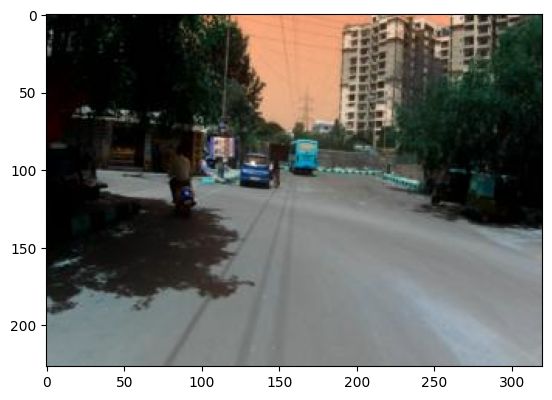

In [ ]:
# Reading a sample image and plotting it
img = cv2.imread(img_train+'29/972458_image.jpg',1)  
plt.imshow(img)

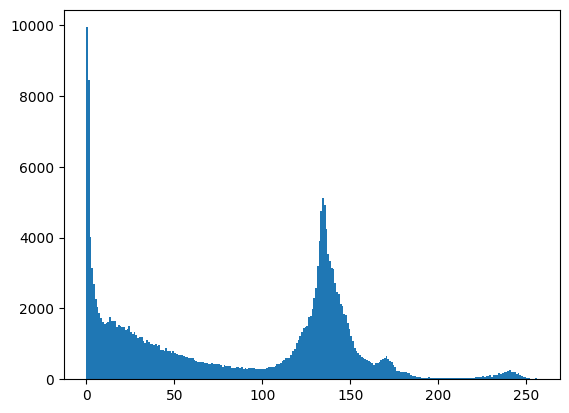

In [ ]:
# Plotting an Histogram to find the frequency of pixel intensity values.
plt.hist(img.ravel(),256,[0,256]) 
plt.show()

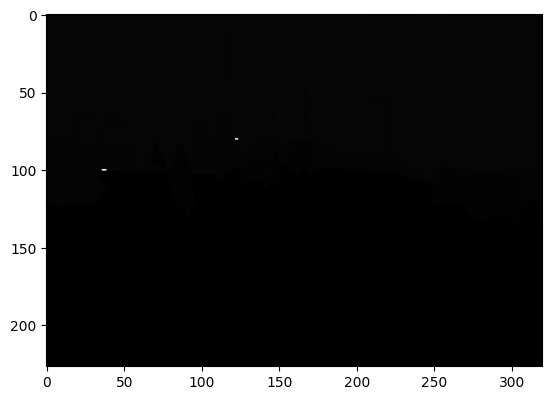

In [ ]:
# Reading the given annotated image for the above sample image
img = cv2.imread(seg_train+'29/972458_label.png',1)  
plt.imshow(img)

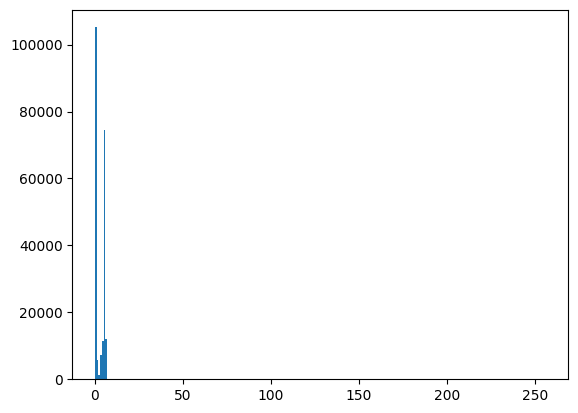

In [ ]:
# Plotting an Histogram to find the frequency of pixels intensity values.
plt.hist(img.ravel(),256,[0,256]) 
plt.show()

In [ ]:
# Frequency Distribution
# This is to find the exact number of pixels corresponind to each class
y = np.bincount(img.flatten())
ii = np.nonzero(y)[0]
np.vstack((ii, y[ii])).T 

array([[     0, 105186],
       [     1,   5832],
       [     2,   1416],
       [     3,   7371],
       [     4,  11481],
       [     5,  74550],
       [     6,  12069],
       [   255,     15]])

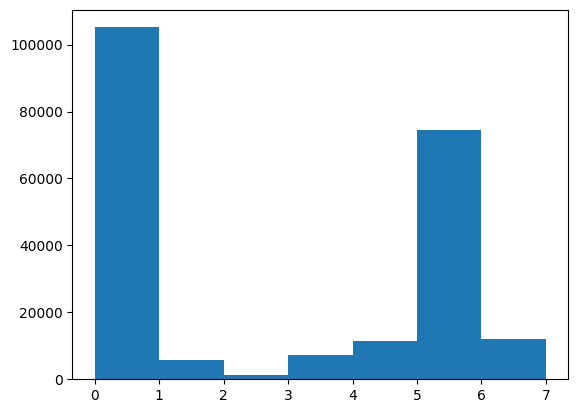

In [ ]:
# Plotting an Histogram to find the frequency of pixels intensity values.
plt.hist(img.ravel(),7,[0,7]) 
plt.show()

Plotting the annotated image after intensifying the pixels

In [4]:
# This function visualizes the segmenetation image by multiplying each pixel with 40
# Reference -> https://github.com/saisandeepNSS/IDD_SemanticSegmentation

def visualizeSegmentationImages(imagepath):
    img_seg = cv2.imread(imagepath,0)
    # We are going to loop through all the pixel values and multiply them by 40 now
    for i in range(len(img_seg)):
        for j in range(len(img_seg[0])):
            if img_seg[i][j] != 0 or img_seg[i][j] != 255:
                # max value will be 6*40=240 which is under 255
                img_seg[i][j] *= 40  
    return img_seg

In [ ]:
# Getting the processed segmentation image for visualization
img_seg = visualizeSegmentationImages(seg_train+'29/972458_label.png')

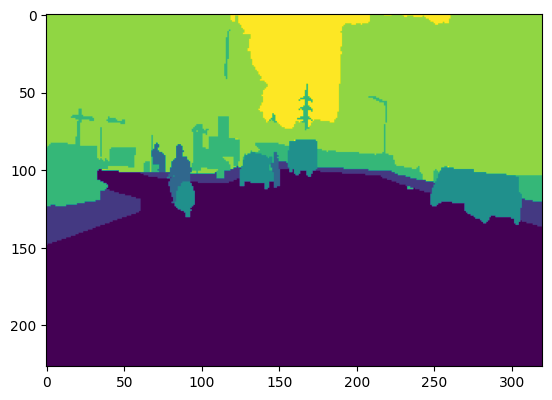

In [ ]:
# Plotting the processed segmentation image
plt.imshow(img_seg)

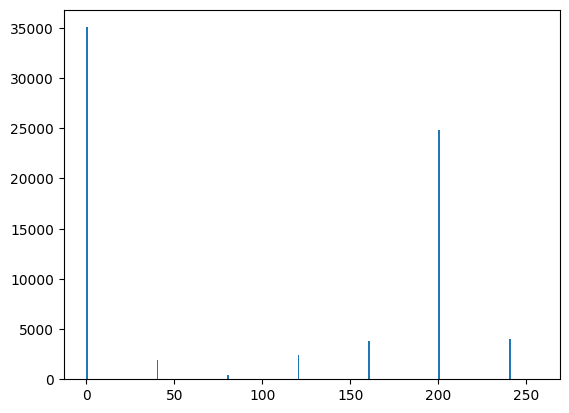

In [ ]:
# Plotting an Histogram to find the frequency of pixels intensity values.
plt.hist(img_seg.ravel(),256,[0,256]) 
plt.show()

Data Preparation

In [5]:

# Image size that we are going to use
(HEIGHT,WIDTH) = (256,256)
# Our images are RGB (3 channels)
N_CHANNELS = 3
# Scene Parsing has 7 classes (0-6) + `not labeled`
N_CLASSES = 7

In [6]:
def parse_image(img_path):
    """
    Load an image and its annotation (mask) and returning a dictionary.
    """
    # Reading the image
    image = tf.io.read_file(img_path)
    image = tf.image.decode_jpeg(image, channels=3)
    # For one Image path:
    # .../idd20k_lite/leftImg8bit/train/024541_image.jpg
    # Its corresponding annotation path is:
    # .../idd20k_lite/gtFine/train/024541_label.png
    mask_path = tf.strings.regex_replace(img_path, "leftImg8bit", "gtFine")
    mask_path = tf.strings.regex_replace(mask_path, "_image.jpg", "_label.png")
    # Reading the annotation file corresponding the image file
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    # In scene parsing, "not labeled" = 255
    # But it will mess with our N_CLASS = 7
    # Since 255 means the 255th class
    # Which doesn't exist
    mask = tf.where(mask==255, np.dtype('uint8').type(7), mask)
    # Note that we have to convert the new value (7)
    # With the same dtype than the tensor itself
    return {'image': image, 'segmentation_mask': mask}

In [7]:
# Reference -> https://www.tensorflow.org/api_docs/python/tf/data/Dataset#list_files
# tf.data.Dataset.list_files returns a dataset of all files matching one or more glob patterns.

train_dataset = tf.data.Dataset.list_files(img_train+'*/*_image.jpg', seed=SEED)
train_dataset = train_dataset.map(parse_image)

val_dataset = tf.data.Dataset.list_files(img_val+'*/*_image.jpg', seed=SEED)
val_dataset = val_dataset.map(parse_image)

In [8]:
# Reference -> https://www.tensorflow.org/api_docs/python/tf/cast
# Returns a Tensor same shape as given tensor and same type as dtype that is mentioned.

def normalize(input_image, input_mask):
    """
    Rescale the pixel values of the images between 0 and 1 compared to [0,255] originally.
    """
    input_image = tf.cast(input_image, tf.float32) / 255.0
    return input_image, input_mask

In [9]:
# Reference -> https://www.tensorflow.org/api_docs/python/tf/image/resize
# Resize images to the size specified

def load_image_train(datapoint):
    """
    Normalize and resize a train image and its annotation.
    Apply random transformations to an input dictionary containing a train image and its annotation.
    """
    input_image = tf.image.resize(datapoint['image'], (HEIGHT,WIDTH))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (HEIGHT,WIDTH))
    if tf.random.uniform(()) > 0.5:
        input_image = tf.image.flip_left_right(input_image)
        input_mask = tf.image.flip_left_right(input_mask)
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

def load_image_test(datapoint):
    """
    Normalize and resize a test image and its annotation.
    Since this is for the test set, we don't need to apply any data augmentation technique.
    """
    input_image = tf.image.resize(datapoint['image'], (HEIGHT,WIDTH))
    input_mask = tf.image.resize(datapoint['segmentation_mask'], (HEIGHT,WIDTH))
    input_image, input_mask = normalize(input_image, input_mask)
    return input_image, input_mask

In [10]:
BATCH_SIZE = 8
BUFFER_SIZE = 1000
dataset = {"train": train_dataset, "val": val_dataset}

In [11]:
# Reference -> https://www.tensorflow.org/api_docs/python/tf/data/Dataset

# Preparing the Train dataset by applying dataset transformations
dataset['train'] = dataset['train'].map(load_image_train, num_parallel_calls=tf.data.experimental.AUTOTUNE)
dataset['train'] = dataset['train'].shuffle(buffer_size=BUFFER_SIZE, seed=SEED)
dataset['train'] = dataset['train'].repeat()
dataset['train'] = dataset['train'].batch(BATCH_SIZE)
dataset['train'] = dataset['train'].prefetch(buffer_size=AUTOTUNE)
print(dataset['train'])

# Preparing the Validation Dataset
dataset['val'] = dataset['val'].map(load_image_test)
dataset['val'] = dataset['val'].repeat()
dataset['val'] = dataset['val'].batch(BATCH_SIZE)
dataset['val'] = dataset['val'].prefetch(buffer_size=AUTOTUNE)
print(dataset['val'])

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))>
<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 1), dtype=tf.float32, name=None))>


Visualizing after processing the data

In [12]:
def display_sample(display_list):
    """
    Show side-by-side an input image,
    the ground truth and the prediction.
    """
    plt.figure(figsize=(15,15))
    title = ['Input Image', 'True Mask', 'Predicted Mask']
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()


In [ ]:
# Getting a sample image for visualizing
for image, mask in dataset['train'].take(1):
    sample_image, sample_mask = image, mask

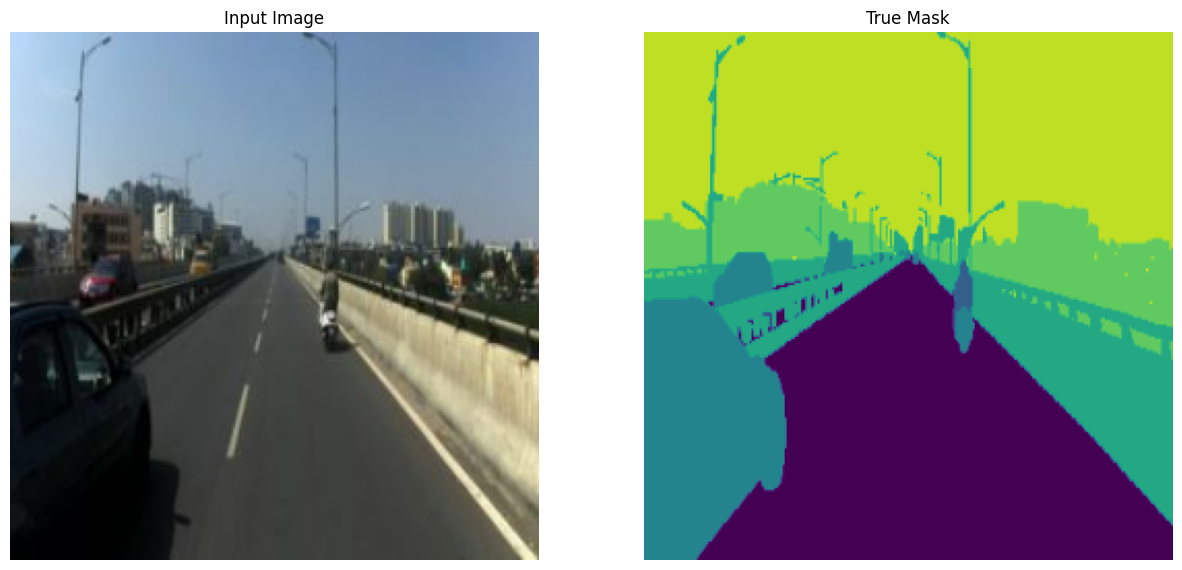

In [ ]:

# Displaying a sample Input Image and its corresponding mask
display_sample([sample_image[0], sample_mask[0]])




Model Building (deeplab_V3)

In [13]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, UpSampling2D
from tensorflow.keras.layers import AveragePooling2D, Conv2DTranspose, Concatenate, Input
from tensorflow.keras.models import Model
from tensorflow.keras.applications import ResNet50


'import torchvision.models as models\nResNet18 = models.resnet18'

In [14]:
encoder_ResNet50 = ResNet50(input_shape =  (256, 256,3), include_top = False, weights = 'imagenet')
encoder_ResNet50.trainable = False

encoder_ResNet50.summary()

94765736/94765736 [==============================] - 5s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                          

In [15]:
def ASPP(inputs):
    shape = inputs.shape

    y_pool = AveragePooling2D(pool_size=(shape[1], shape[2]), name='average_pooling')(inputs)
    y_pool = Conv2D(filters=256, kernel_size=1, padding='same', use_bias=False)(y_pool)
    y_pool = BatchNormalization(name=f'bn_1')(y_pool)
    y_pool = Activation('relu', name=f'relu_1')(y_pool)
    y_pool = UpSampling2D((shape[1], shape[2]), interpolation="bilinear")(y_pool)

    y_1 = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(inputs)
    y_1 = BatchNormalization()(y_1)
    y_1 = Activation('relu')(y_1)
    
    y_8 = Conv2D(filters=256, kernel_size=3, dilation_rate=8, padding='same', use_bias=False)(inputs)
    y_8 = BatchNormalization()(y_8)
    y_8 = Activation('relu')(y_8)
    
    y_16 = Conv2D(filters=256, kernel_size=3, dilation_rate=16, padding='same', use_bias=False)(inputs)
    y_16 = BatchNormalization()(y_16)
    y_16 = Activation('relu')(y_16)
    
    y_32 = Conv2D(filters=256, kernel_size=3, dilation_rate=32, padding='same', use_bias=False)(inputs)
    y_32 = BatchNormalization()(y_32)
    y_32 = Activation('relu')(y_32)

    y_64 = Conv2D(filters=256, kernel_size=3, dilation_rate=64, padding='same', use_bias=False)(inputs)
    y_64 = BatchNormalization()(y_64)
    y_64 = Activation('relu')(y_64)
=
    y = Concatenate()([y_pool, y_1, y_8,y_16,y_32, y_64])

    y = Conv2D(filters=256, kernel_size=1, dilation_rate=1, padding='same', use_bias=False)(y)
    y = BatchNormalization()(y)
    y = Activation('relu')(y)
    return y

In [16]:
def DeepLabV3Plus(n_classes=7, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=1):
    """ Inputs """

    inputs = Input((IMG_HEIGHT, IMG_WIDTH, IMG_CHANNELS))

    """ Pre-trained ResNet50 """

    base_model = ResNet50(weights='imagenet', include_top=False, input_tensor=inputs)

    """ Pre-trained ResNet50 Output """
    image_features = base_model.get_layer('conv4_block6_out').output
    x_a = ASPP(image_features)
    x_a = UpSampling2D((4, 4), interpolation="bilinear")(x_a)

    """ Get low-level features """
    x_b = base_model.get_layer('conv2_block2_out').output
    x_b = Conv2D(filters=48, kernel_size=1, padding='same', use_bias=False)(x_b)
    x_b = BatchNormalization()(x_b)
    x_b = Activation('relu')(x_b)

    x = Concatenate()([x_a, x_b])

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu',use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)

    x = Conv2D(filters=256, kernel_size=3, padding='same', activation='relu', use_bias=False)(x)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = UpSampling2D((4, 4), interpolation="bilinear")(x)

    """ Outputs """
    x = Conv2D(n_classes, (1, 1), activation='softmax')(x)
    x = Activation('sigmoid')(x)

    model = Model(inputs=[inputs], outputs=[x])
    
    return model


In [17]:
def get_model():
    return DeepLabV3Plus(n_classes=8, IMG_HEIGHT=256, IMG_WIDTH=256, IMG_CHANNELS=3)

In [18]:
model = get_model()

In [19]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 262, 262, 3)  0           ['input_2[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 128, 128, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

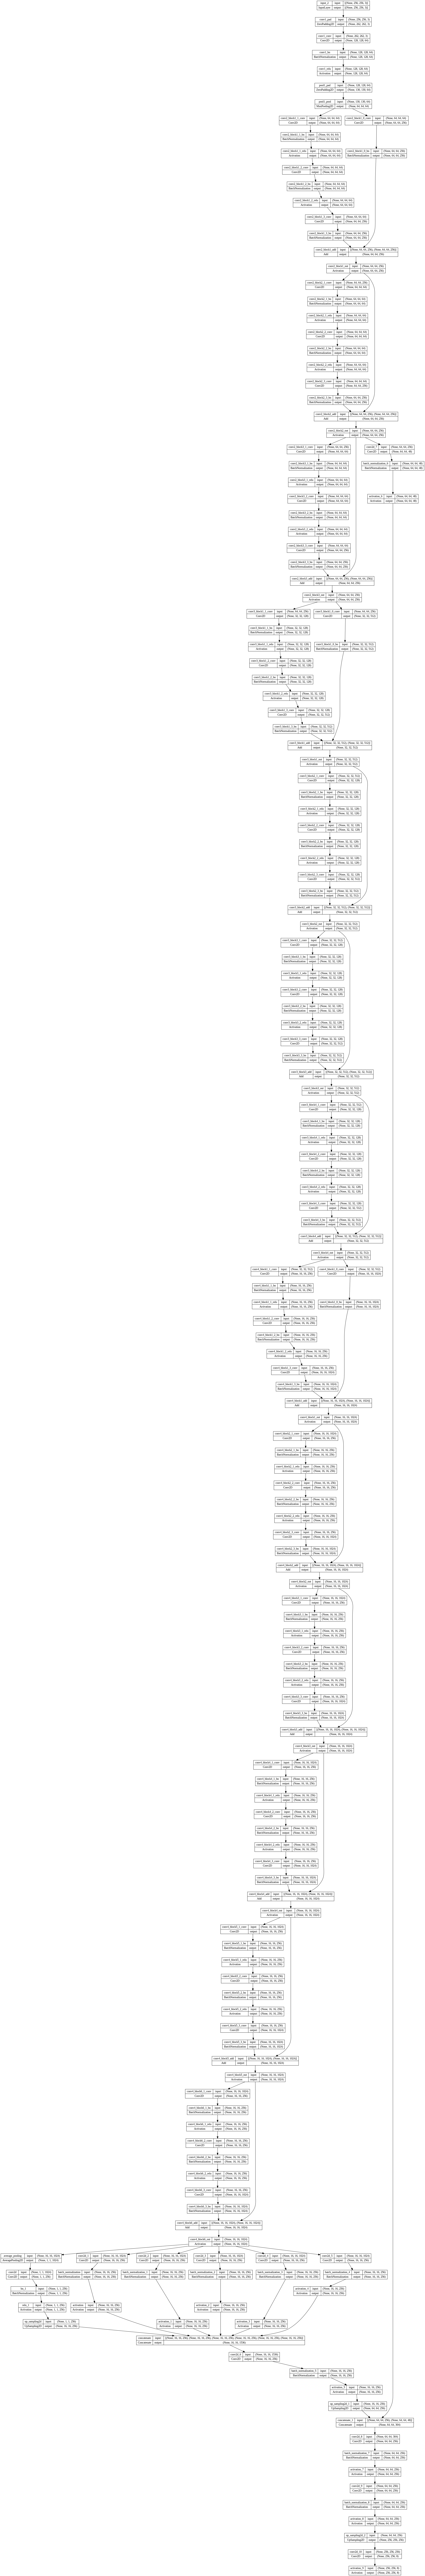

In [ ]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [20]:
# Defining a loss object and an optimizer
loss_object = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.Adam()
ckpt = tf.train.Checkpoint(step=tf.Variable(1), optimizer=optimizer, net=model)
manager = tf.train.CheckpointManager(ckpt, 'tf_ckpts/', max_to_keep=3)

In [21]:

# Define the metrics
train_loss = tf.keras.metrics.Mean('train_loss', dtype=tf.float32)
train_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('train_accuracy')
test_loss = tf.keras.metrics.Mean('test_loss', dtype=tf.float32)
test_accuracy = tf.keras.metrics.SparseCategoricalAccuracy('test_accuracy')

In [22]:
# Reference -> https://github.com/junhoning/machine_learning_tutorial/blob/b20b8a10438ec3e62f08f920744cc8ea854cde91/Visualization%20%26%20TensorBoard/%5BTensorBoard%5D%20Semantic%20Segmentation.ipynb

@tf.function
def train_step(model, optimizer, x_train, y_train):
    with tf.GradientTape() as tape:
        predictions = model(x_train, training=True)
        loss = loss_object(y_train, predictions)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    train_loss(loss)
    train_accuracy(y_train, predictions)
    
def train_and_checkpoint(model, manager, dataset, epoch):
    ckpt.restore(manager.latest_checkpoint)
    if manager.latest_checkpoint:
        print("Restored from {}".format(manager.latest_checkpoint))
    else:
        print("Initializing from scratch.")
    for (x_train, y_train) in dataset['train'].take(math.ceil(1403/32)):
        train_step(model, optimizer, x_train, y_train)
    ckpt.step.assign_add(1)
    save_path = manager.save()
    print("Saved checkpoint for epoch {}: {}".format(epoch, save_path))
    
@tf.function
def test_step(model, x_test, y_test):
    predictions = model(x_test)
    loss = loss_object(y_test, predictions)
    test_loss(loss)
    test_accuracy(y_test, predictions)
    return predictions

In [23]:
# Summary writers for Tensorboard visualization
train_log_dir = 'logs/gradient_tape/train'
test_log_dir = 'logs/gradient_tape/test'
train_summary_writer = tf.summary.create_file_writer(train_log_dir)
test_summary_writer = tf.summary.create_file_writer(test_log_dir)

In [24]:
# This variable will help to save the best model if its performance increases after an epoch   
highest_accuracy = 0

for epoch in range(50):

    print("Epoch ",epoch+1)
    
    # Getting the current time before starting the training
    # This will help to keep track of how much time an epoch took
    start = time.time()
    
    train_and_checkpoint(model, manager, dataset, epoch+1)
    
    # Saving the train loss and train accuracy metric for TensorBoard visualization
    with train_summary_writer.as_default():
        tf.summary.scalar('loss', train_loss.result(), step=ckpt.step.numpy())
        tf.summary.scalar('accuracy', train_accuracy.result(), step=ckpt.step.numpy())
    
    # Validation phase
    for (x_test, y_test) in dataset['val'].take(math.ceil(204/32)):
        pred = test_step(model, x_test, y_test)
    
    # Saving the validation loss and validation accuracy metric for Tensorboard visualization
    with test_summary_writer.as_default():
        tf.summary.scalar('loss', test_loss.result(), step=ckpt.step.numpy())
        tf.summary.scalar('accuracy', test_accuracy.result(), step=ckpt.step.numpy())
    
    # Calculating the time it took for the entire epoch to run
    print("Time taken ",time.time()-start)
    
    # Printing the metrics for the epoch
    template = 'Epoch {}, Loss: {:.3f}, Accuracy: {:.3f}, Val Loss: {:.3f}, Val Accuracy: {:.3f}'
    print (template.format(epoch+1,
                            train_loss.result(), 
                            train_accuracy.result()*100,
                            test_loss.result(), 
                            test_accuracy.result()*100))
    
    # If accuracy has increased in this epoch, updating the highest accuracy and saving the model
    if(test_accuracy.result().numpy()*100>highest_accuracy):
        print("Validation accuracy increased from {:.3f} to {:.3f}. Saving model weights.".format(highest_accuracy,test_accuracy.result().numpy()*100))
        highest_accuracy = test_accuracy.result().numpy()*100
        model.save_weights('DeeplabV3Plus_Di8&16&32&64_weights-epoch-{}.hdf5'.format(epoch+1+25))

    print('_'*80)

    # Reset metrics after every epoch
    train_loss.reset_states()
    test_loss.reset_states()
    train_accuracy.reset_states()
    test_accuracy.reset_states()

Epoch  1
Initializing from scratch.
Saved checkpoint for epoch 1: tf_ckpts/ckpt-1
Time taken  1090.06338763237
Epoch 1, Loss: 1.515, Accuracy: 75.050, Val Loss: 2.044, Val Accuracy: 22.194
Validation accuracy increased from 0.000 to 22.194. Saving model weights.
________________________________________________________________________________
Epoch  2
Restored from tf_ckpts/ckpt-1
Saved checkpoint for epoch 2: tf_ckpts/ckpt-2
Time taken  89.1445209980011
Epoch 2, Loss: 1.478, Accuracy: 78.070, Val Loss: 1.749, Val Accuracy: 51.737
Validation accuracy increased from 22.194 to 51.737. Saving model weights.
________________________________________________________________________________
Epoch  3
Restored from tf_ckpts/ckpt-2
Saved checkpoint for epoch 3: tf_ckpts/ckpt-3
Time taken  58.6158230304718
Epoch 3, Loss: 1.474, Accuracy: 78.339, Val Loss: 1.763, Val Accuracy: 50.361
________________________________________________________________________________
Epoch  4
Restored from tf_ckpts/ckp

In [31]:
!tensorboard dev upload --logdir /content/logs --name "modified DeepLabV3+" --description "MTP"


2023-05-05 08:30:58.400800: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT

***** TensorBoard Uploader *****

This will upload your TensorBoard logs to https://tensorboard.dev/ from
the following directory:

/content/logs

This TensorBoard will be visible to everyone. Do not upload sensitive
data.

Your use of this service is subject to Google's Terms of Service
<https://policies.google.com/terms> and Privacy Policy
<https://policies.google.com/privacy>, and TensorBoard.dev's Terms of Service
<https://tensorboard.dev/policy/terms/>.

This notice will not be shown again while you are logged into the uploader.
To log out, run `tensorboard dev auth revoke`.

Continue? (yes/NO) yes

To sign in with the TensorBoard uploader:

1. On your computer or phone, visit:

   https://www.google.com/device

2. Sign in with your Google account, then enter:

   XLG-PJB-QQN


Upload started and will continue reading any new data as it's added to the logdir

In [ ]:
# New experiment created. View your TensorBoard at: https://tensorboard.dev/experiment/pR2ETzvyRpe1HmY20Y2Grw/
#https://tensorboard.dev/experiment/JZLXzoX4SQqoZ67GhXgYxQ/#scalars

Screenshot (643).png

In [25]:
# Loading the weights of the best model
model.load_weights('/content/DeeplabV3Plus_Di8&16&32&64_weights-epoch-48.hdf5')

In [26]:
def predict(model,image_path):
    """
    This function will take the model which is going to be used to predict the image and the image path of 
    the input image as inputs and predict the mask
    It returns the true mask and predicted mask
    """
    # Getting the datapoint
    # This function will load the image and its annotation (mask) and return a dictionary.
    datapoint = parse_image(image_path)
    # Normalizing the resizing the datapoint
    input_image,image_mask = load_image_test(datapoint)
    # As the model takes input with 4 dimensions (batch_size, rows, columns, channels),
    # and the shape of the input image is (rows, columns, channels)
    # we will expand the first dimension so we will get the shape as  (1, rows, columns, channels)
    img = tf.expand_dims(input_image, 0)
    # Predicting the image by passing it to the model
    prediction = model(img)
    # The model will predict 8 outputs for each pixel
    # We have to get the maximum value out of it
    prediction = tf.argmax(prediction, axis=-1)
    prediction = tf.squeeze(prediction, axis = 0)
    pred_mask = tf.expand_dims(prediction, axis=-1)
    # Displaying the input image, true mask, predicted mask
    # Uncomment this when you want to display the results
    display_sample([input_image, image_mask, pred_mask])
    return image_mask, pred_mask

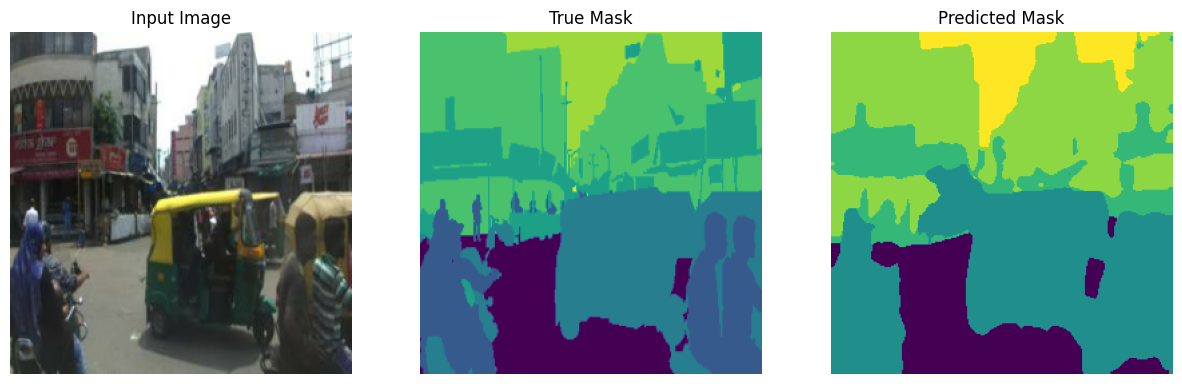

In [38]:
# Calling the predict function
true_mask, pred_mask = predict(model,'/content/drive/MyDrive/idd20k_lite/leftImg8bit/val/66/831898_image.jpg')

In [28]:
# Reference -> https://github.com/saisandeepNSS/IDD_SemanticSegmentation

def IoU(y_i,y_pred):
    # This function calculates the mean Intersection over Union
    # Mean IoU = TP/(FN + TP + FP)
    # This list will save the IoU of all the classes
    IoUs = []
    # Defining the number of classes which the model has predicted
    n_classes = 7
    for c in range(n_classes):
        # Calculating the True Positives
        TP = np.sum((y_i == c)&(y_pred==c))
        # Calculating the False Positives
        FP = np.sum((y_i != c)&(y_pred==c))
        # Calculating the False Negatives
        FN = np.sum((y_i == c)&(y_pred!= c))
        # Calculating the IoU for the particular class
        IoU = TP/float(TP + FP + FN)
        # Printing the outputs
        # Uncomment the print statement below when you want to analyze the results for each class
        print("class {:02.0f}: #TP={:6.0f}, #FP={:6.0f}, #FN={:5.0f}, IoU={:4.3f}".format(c,TP,FP,FN,IoU))
        # Appending the IoU to the list as it mean needs to be calculated later
        if(math.isnan(IoU)):
            IoUs.append(0)
            continue
        IoUs.append(IoU)
    # Calculating the mean
    mIoU = np.mean(IoUs)
    #print("_________________")
    # Uncomment this when you want to print the mean IoU
    print("Mean IoU: {:4.3f}".format(mIoU))
    return mIoU

In [ ]:
IoU(true_mask, pred_mask)